# rosita

*rosita* is a fork of a subset of librosa. The idea behind it is to access some of the well tested functionality without including all dependencies that librosa has. In particular librosa depends on numba, which poses clear problems regarding numpy and in the end limits the python version for the entire project. *rosita* extracts just some of the algorithms plus the needed utility functions and keeps all names and arguments, so that it can be a drop-in replacement. At the moment *rosita* is included in *maelzel*, but it might be ported out as an independent project in the future. 


In [1]:
from maelzel.snd import audiosample
from maelzel.snd import rosita
import matplotlib.pyplot as plt
import csoundengine as ce
import numpy as np

plt.rcParams["figure.figsize"] = (21,8)

In [2]:
s = audiosample.Sample("../snd/onset-detection-test.flac")
s.samples

array([0., 0., 0., ..., 0., 0., 0.])

Sample(dur=26.428049886621316, sr=44100, ch=1)
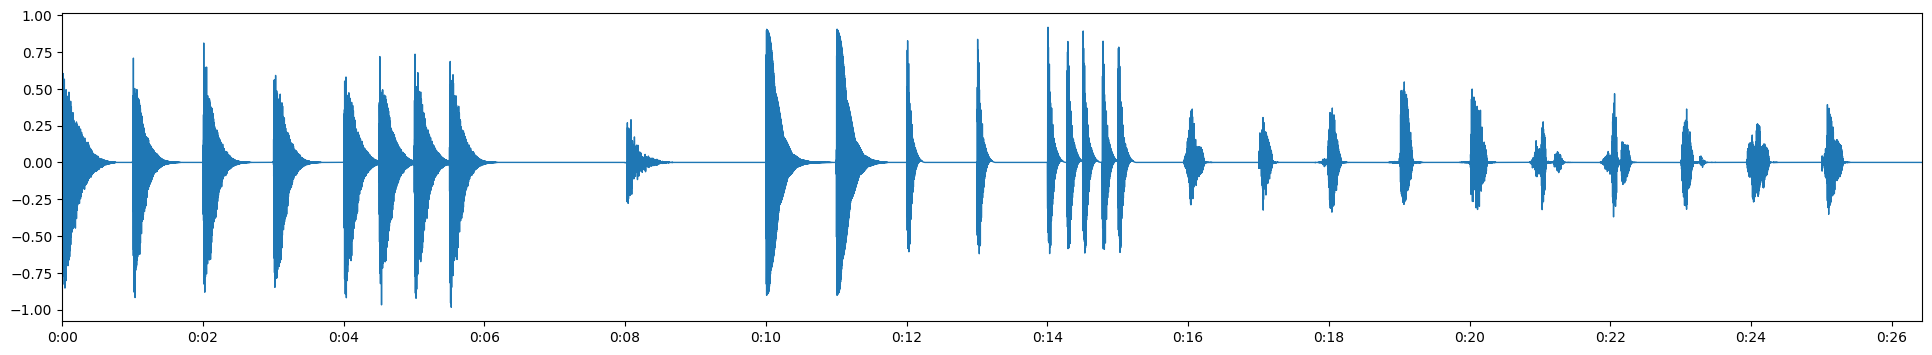

In [3]:
s

In [3]:
s.play(pan=0.5)




--Csound version 6.19 (double samples) Oct 30 2023
[commit: 79e5d31bea441e5289073319ab2b1e42d01814b9]
libsndfile-1.2.0
sr = 48000.0, kr = 750.000, ksmps = 64
0dBFS level = 1.0, A4 tuning = 440.0
audio buffered in 512 sample-frame blocks
reading 4096-byte blks of shorts from adc:Built-in Audio Pro: (RAW)
writing 1024 sample blks of 64-bit floats to dac:Built-in Audio Pro:
SECTION 1:


Button(description='Stop', style=ButtonStyle())

Output()

Synth(𝍪 .playSample=501.0002 start=0.339 dur=-1.000 p4=104 isndtab=0 istart=0.05 ifadein=0.05 ifadeout=1 kchan=1 kspeed=1 kgain=0.5 kpan=-1)

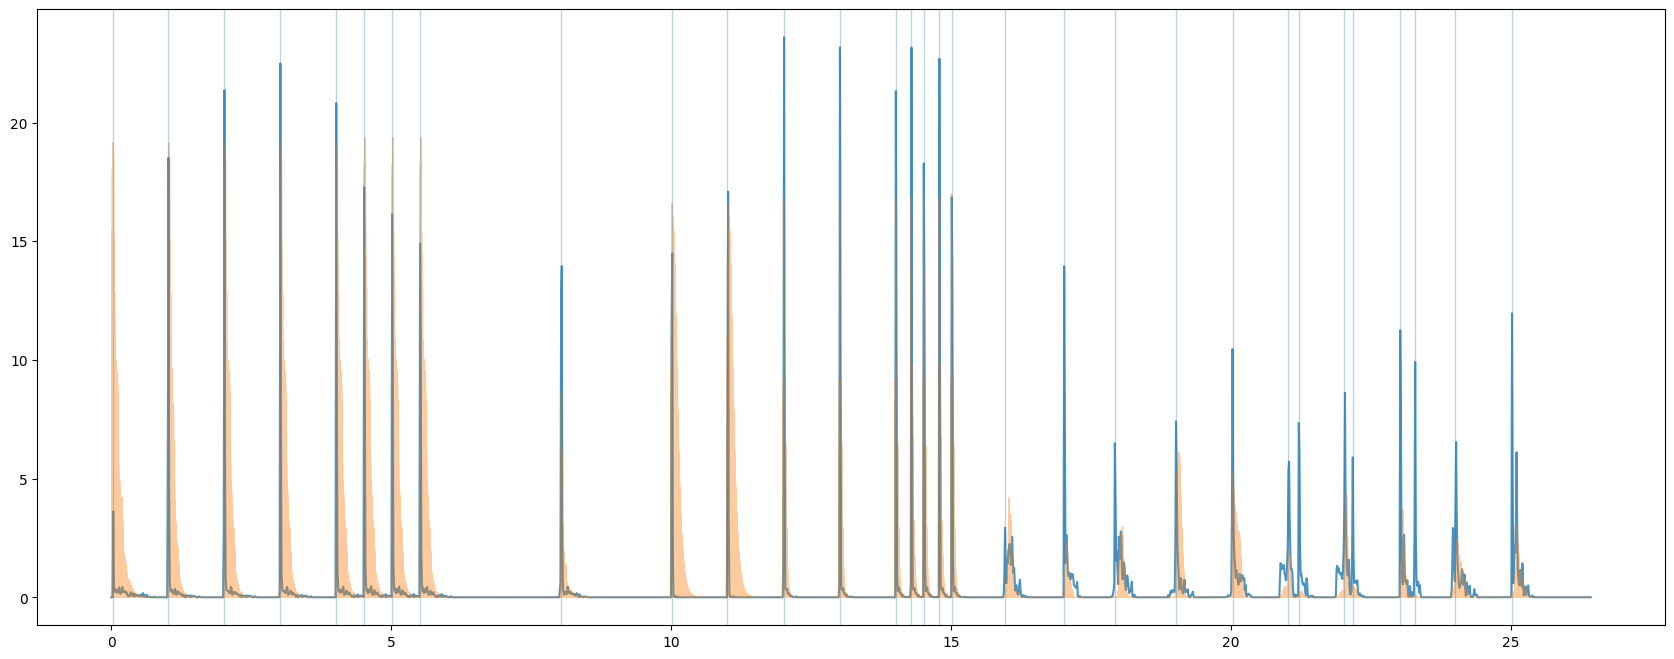

In [4]:
hop = 512
env = rosita.onset_strength(y=s.samples, sr=s.sr, hop_length=hop)
envtimes = rosita.times_like(env, sr=s.sr, hop_length=hop)
onsets = rosita.onset_detect(s.samples, s.sr, onset_envelope=env, hop_length=hop, units='time', delta=0.07, mingap=0.15)

plt.plot(envtimes, env, alpha=0.8)
plt.plot(np.arange(0, s.duration, 1/s.sr), s.samples**2*20, alpha=0.4, linewidth=1)
for onset in onsets:
    plt.axvline(x=onset, alpha=0.3, linewidth=1)

In [5]:
session = audiosample.Sample.getEngine().session()
session.defInstr('click', r'''
|iamp=0.5|
a0 = oscili(iamp, 1000)
aenv = expseg:a(0.00001, 0.005, 1, 0.1, 0.0001)
a0 *= aenv
outch 1, a0
''')

Instr(click, iamp:5=0.5)

In [7]:
with session :
    session.playSample((s.samples, s.sr), pan=1)
    synths = [session.sched('click', delay=onset, dur=0.05, iamp=0.8)
              for onset in onsets]

In [8]:
session.unschedAll()

UnifiedCSD:  /tmp/tmpci839asd.csd
instr _releaseDynargsToken uses instrument number 1
instr _stop uses instrument number 2
instr _setControl uses instrument number 3
instr _initDynamicControls uses instrument number 4
instr _automateControlViaPargs uses instrument number 5
instr _automatePargViaPargs uses instrument number 6
instr _pwrite uses instrument number 7
instr _chnset uses instrument number 8
PSET: isname="_initDynamicControls", pmax=5

Elapsed time at end of orchestra compile: real: 0.022s, CPU: 0.022s
sorting score ...
	... done
Elapsed time at end of score sort: real: 0.024s, CPU: 0.023s
--Csound version 6.19 (double samples) Oct 30 2023
[commit: 79e5d31bea441e5289073319ab2b1e42d01814b9]
libsndfile-1.2.0
graphics suppressed, ascii substituted
sr = 48000.0, kr = 750.000, ksmps = 64
0dBFS level = 1.0, A4 tuning = 442.0
ftable 101:
ftable 101:	100000 points, scalemax 0.000
ftable 102:
ftable 102:	1000 points, scalemax 0.000
ftable 103:
ftable 103:	100 points, scalemax 0.000
ft


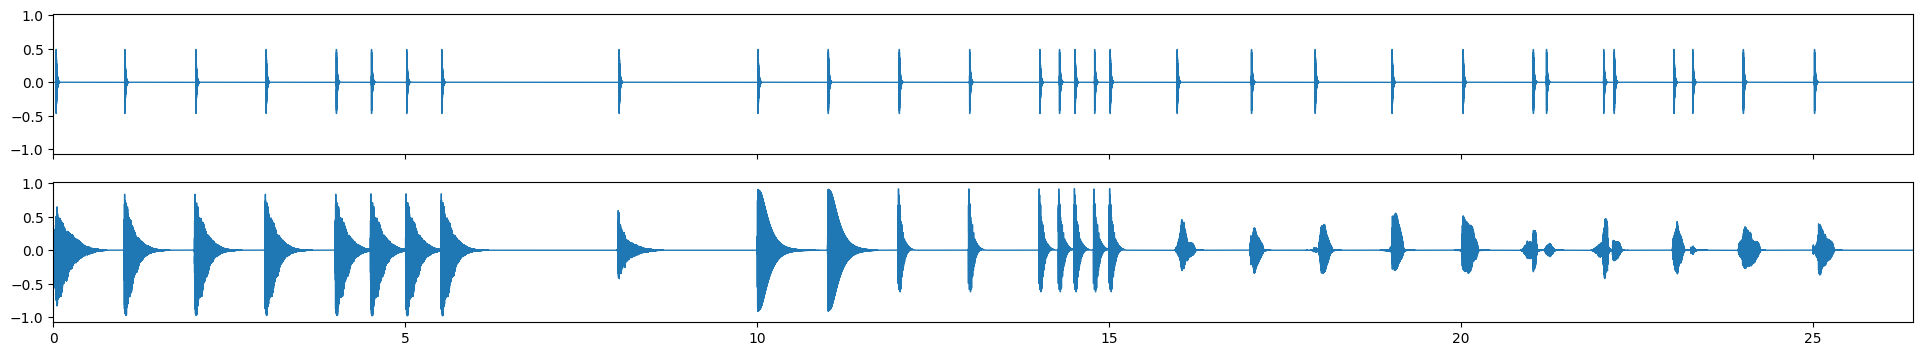

In [8]:
with session.rendering('onsets.flac') as r:
    synths = [r.sched('click', delay=onset, dur=0.05)
              for onset in onsets]
    r.playSample((s.samples, s.sr), pan=1)
r